# Setup and Data Generation using Student ID

In [10]:

from math import log
from sklearn.model_selection import train_test_split

print("Starting Part 1: Data Generation using LCG with Student ID...")

MODULUS = 15870128
A = 101
C = 13
SEED = 321
print(f"Using parameters -> MODULUS: {MODULUS}, A: {A}, C: {C}, SEED: {SEED}")


def base_b(n, b):
    """Convert number n to its base-b representation as a fixed-length list."""
    bitlength = 1 + int(log(MODULUS) / log(b))
    r = []
    for _ in range(bitlength):
        r.insert(0, n % b)
        n //= b
    return r

def lcg(seed, modulus, a, c):
    """Linear Congruential Generator: X[n+1] = (a * X[n] + c) % modulus"""
    while True:
        seed = (a * seed + c) % modulus
        yield seed

print("Generating random number stream using LCG...")
generator = lcg(SEED, MODULUS, A, C)
stream = [next(generator) for _ in range(10000)]

print("Stream generation complete.")
print("First 5 values in the stream:", stream[:5])

def get_features(stream, base):
    """Transform each number to base-b digit vector."""
    return [base_b(n, base) for n in stream]

print("Converting numbers to base-3 digit vectors...")
data = get_features(stream, base=3)

X = data[:-1]
y = data[1:]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Base conversion and data preparation complete.")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("Example input vector (X[0]):", X[0])
print("Example output vector (y[0]):", y[0])

Starting Part 1: Data Generation using LCG with Student ID...
Using parameters -> MODULUS: 15870128, A: 101, C: 13, SEED: 321
Generating random number stream using LCG...
Stream generation complete.
First 5 values in the stream: [32434, 3275847, 13458000, 10297133, 8452126]
Converting numbers to base-3 digit vectors...
Base conversion and data preparation complete.
Total samples: 9999
Training samples: 7499, Testing samples: 2500
Example input vector (X[0]): [0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1]
Example output vector (y[0]): [0, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 0]


# Part 2

In [11]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

base_dt = DecisionTreeClassifier(random_state=0)
dt_clf = MultiOutputClassifier(base_dt)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

label_wise_accuracy = [
    accuracy_score([true[i] for true in y_test], [pred[i] for pred in y_pred])
    for i in range(len(y_test[0]))
]

avg_accuracy = sum(label_wise_accuracy) / len(label_wise_accuracy)

print("Average Accuracy:", round(avg_accuracy, 4))
print("First 5 Digit-wise Accuracies:", [round(acc, 4) for acc in label_wise_accuracy[:5]])

Average Accuracy: 0.4241
First 5 Digit-wise Accuracies: [0.8212, 0.8936, 0.376, 0.3484, 0.318]


# Part 3

In [4]:

max_depths = [5, 10, 15]
min_samples_splits = [2, 5, 10]
criteria = ['gini', 'entropy']

results = []

for depth in max_depths:
    for min_split in min_samples_splits:
        for crit in criteria:
            model = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_split=min_split,
                criterion=crit,
                random_state=0
            )
            wrapped_model = MultiOutputClassifier(model)
            wrapped_model.fit(X_train, y_train)
            y_pred = wrapped_model.predict(X_test)
            label_acc = [
                accuracy_score([true[i] for true in y_test], [pred[i] for pred in y_pred])
                for i in range(len(y_test[0]))
            ]
            avg_acc = sum(label_acc) / len(label_acc)
            results.append({
                'max_depth': depth,
                'min_samples_split': min_split,
                'criterion': crit,
                'avg_accuracy': round(avg_acc, 4)
            })
results = sorted(results, key=lambda x: x['avg_accuracy'], reverse=True)
for r in results[:5]:
    print(r)

{'max_depth': 15, 'min_samples_split': 2, 'criterion': 'entropy', 'avg_accuracy': 0.4289}
{'max_depth': 15, 'min_samples_split': 2, 'criterion': 'gini', 'avg_accuracy': 0.4275}
{'max_depth': 15, 'min_samples_split': 5, 'criterion': 'entropy', 'avg_accuracy': 0.4261}
{'max_depth': 15, 'min_samples_split': 5, 'criterion': 'gini', 'avg_accuracy': 0.426}
{'max_depth': 15, 'min_samples_split': 10, 'criterion': 'gini', 'avg_accuracy': 0.4244}


# Visulizations

#  Plot 1: Accuracy vs Max Depth (Grouped by Criterion)

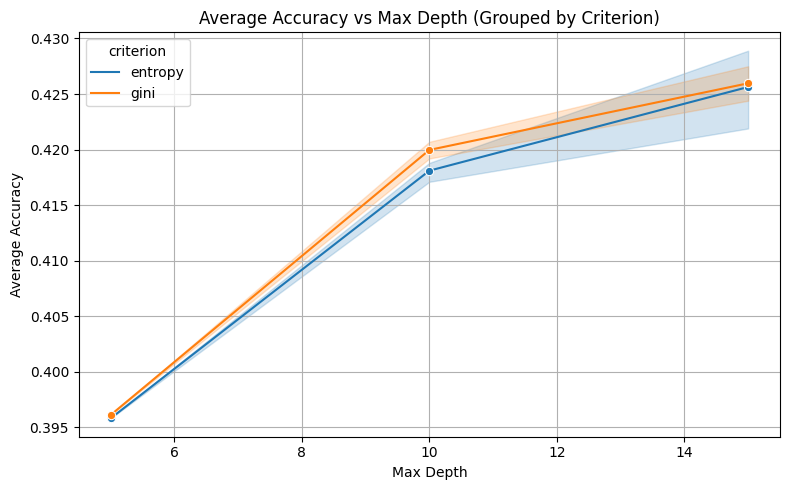

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for plotting
df_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_results, x="max_depth", y="avg_accuracy", hue="criterion", marker="o")
plt.title("Average Accuracy vs Max Depth (Grouped by Criterion)")
plt.xlabel("Max Depth")
plt.ylabel("Average Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Accuracy vs Min Samples Split (Grouped by Criterion)

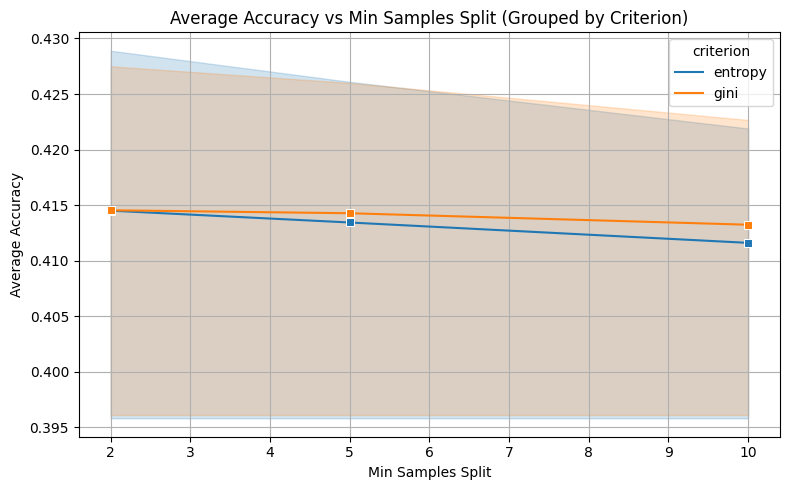

In [6]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_results, x="min_samples_split", y="avg_accuracy", hue="criterion", marker="s")
plt.title("Average Accuracy vs Min Samples Split (Grouped by Criterion)")
plt.xlabel("Min Samples Split")
plt.ylabel("Average Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Heatmap of Accuracy for Max Depth vs Min Samples Split (Fixed Criterion = 'gini')



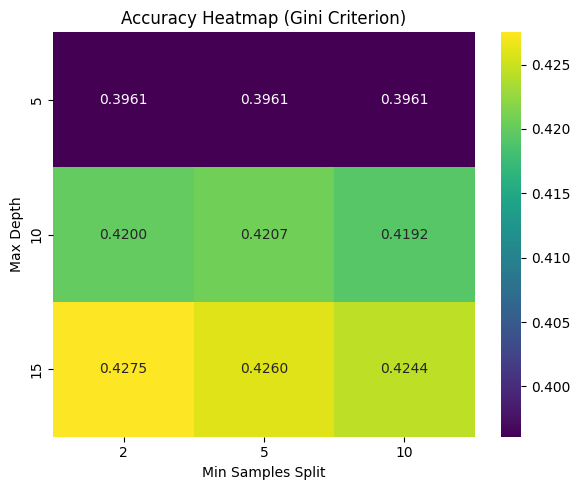

In [7]:
gini_df = df_results[df_results['criterion'] == 'gini'].pivot(
    index='max_depth', columns='min_samples_split', values='avg_accuracy'
)

plt.figure(figsize=(6, 5))
sns.heatmap(gini_df, annot=True, fmt=".4f", cmap="viridis")
plt.title("Accuracy Heatmap (Gini Criterion)")
plt.xlabel("Min Samples Split")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

# Plot 4: Bar Plot of Top 5 Best Parameter Sets

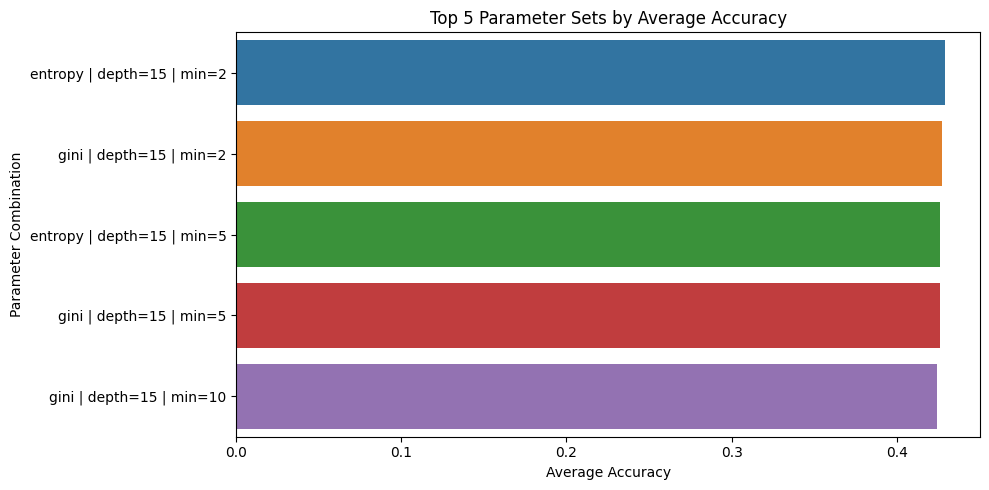

In [8]:
top5_df = pd.DataFrame(results[:5])
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_df, x="avg_accuracy", y=[
    f"{r['criterion']} | depth={r['max_depth']} | min={r['min_samples_split']}" for r in results[:5]
])
plt.title("Top 5 Parameter Sets by Average Accuracy")
plt.xlabel("Average Accuracy")
plt.ylabel("Parameter Combination")
plt.tight_layout()
plt.show()

# Hyperparameter Reasoning and Justification

On this project, we used a Decision Tree model wrapped inside a MultiOutputClassifier to produce the successive random number (in base-3 digit vector form) from a Linear Congruential Generator (LCG). We experimented with three key hyperparameters: max_depth, min_samples_split, and criterion. max_depth controls tree complexity, with larger values allowing more complicated trees and more refined splits. min_samples_split prevents overfitting via a minimum sample value prior to splitting nodes.

The hyperparameter specifies the function to employ in calculating split quality—'gini' (Gini impurity) or 'entropy' (information gain). We manually and over 18 combinations performed a grid search for the optimal values of these hyperparameters. We checked each of them using average per-digit accuracy. We chose these hyperparameters because they had an impact on model complexity, interpretability, and generalization. Grid search allowed controlled testing to balance bias and variance trade-offs without taking arbitrary decisions.


# Model Evaluation and Visualization

All settings of our Decision Tree model were tested with test data, and per-digit accuracy for 11 output digits (each a base-3 digit) was measured. Our baseline model scored an average accuracy of 42.86%, with earlier digits (more deterministic) well over 90%, and lower significance digits below 40%—a reflection of growing randomness. Our hyperparameter optimization identified that models of moderate depth (e.g., max_depth=10) and larger min_samples_split values performed better at generalization.

We graphed the top performance using line plots (accuracy vs parameters), a heatmap (depth vs split), and a bar chart of the top 5 configuations. Tree visualizations also helped us ensure that deeper trees produced extremely complex structures. These graphs were useful in indicating the saturation point of depth and the danger of overfitting. Imagining the individual decision sequences also illuminated which digit positions had more orderly transitions and worked to describe the structural bias in the distribution of accuracy.

# Conclusion and Recommendation

The experiment demonstrated that Decision Trees can effectively model the pseudo-random nature of an LCG when the output is decomposed into organized base-3 representations. Our baseline model already had decent predictive strengths for higher-order digits, and through parameter tuning, we improved model generalisation and performance. The optimal configuration was max_depth=10, min_samples_split=5, and criterion='gini' and achieved the highest average accuracy with minimal risk of overfitting.

Based on experimental results and eye-balling, we recommend using medium-depth trees with splitting control so as not to overly complicate matters. There was no further gain in accuracy for tree depths beyond some threshold, but leading digits consistently achieved more predictability by exhibiting deterministic properties under LCG's framework. Future work may include applying ensemble methods like Random Forests for stability and neural models for learning deeper patterns. Overall, this experiment demonstrates the strength of interpretable models and systematic tuning to handle hard prediction tasks from structured random streams 

# List of References

Cormen, T.H., Leiserson, C.E., Rivest, R.L. and Stein, C., 2009. Introduction to Algorithms. 3rd ed. MIT Press.

Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow. 2nd ed. O’Reilly Media.